In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
import itertools
%load_ext rpy2.ipython

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 12
LINE_COLORS = {
    "AX4": "#000000",
    "B1": "#00B2FF",
    "C1": "#A400D3",
    "rgB": "#008528",
    "B1_rgB": "#D9D800",
    "AX4L846F": "#ED1C24",
}
NAME_DICT = {
    "AX4": "AX4",
    "B1": "tgrB1-",
    "C1": "tgrC1-",
    "rgB": "rapgapB-",
    "B1_rgB": "rapgapB-tgrB1-",
    "AX4L846F": "AX4 L846F",
}
P_VALUE = 0.05

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [77]:
STRAINS = ["AX4", "B1", "C1", "rgB", "B1_rgB", "AX4L846F"]
gene_lists = {}

In [78]:
file_paths = {}
ALL_GENES = set()
for strain in STRAINS[1:]:
    file_path = f"../results/time_series/genes/DE_{strain}.csv"
    data = pd.read_csv(file_path)
    ALL_GENES = ALL_GENES.union(set(list(data["row_IDs"])))

In [79]:
def load_filtered_gene_lists(
    strains: list,
    p_val_threshold: float = None,
    top_n: int = None,
):
    file_paths = {}
    for strain in strains:
        file_paths[strain] = f"../results/time_series/genes/DE_{strain}.csv"

    gene_lists = {}

    for name, path in file_paths.items():
        df = pd.read_csv(path)
        df = df.sort_values(by="adj.P.Val")
        df2 = df.copy()
        if top_n is not None:
            df = df.head(top_n)
        if p_val_threshold is not None:
            df = df[df["adj.P.Val"] < p_val_threshold]
            df2 = df2[df2["adj.P.Val"] >= p_val_threshold]
        gene_lists[name] = set(list(df["row_IDs"]))

    return gene_lists

In [80]:

gene_lists= load_filtered_gene_lists(
    STRAINS[1:],
    p_val_threshold=P_VALUE,
)            

In [81]:
REFERENCE = "AX4"
other_strains = [strain for strain in STRAINS if strain != REFERENCE]

In [82]:
print(gene_lists.keys())

dict_keys(['B1', 'C1', 'rgB', 'B1_rgB', 'AX4L846F'])


In [83]:
count_dictionary = {}
count_dictionary[(REFERENCE,)] = ALL_GENES
for i in range(0, len(other_strains)):
    curr_strains = other_strains[:i]
    all_combinations = [
        c
        for r in range(len(curr_strains), 0, -1)
        for c in itertools.combinations(curr_strains, r)
    ]
    new_strain = other_strains[i]
    curr_strain = gene_lists[new_strain]
    curr_strain_ax4 = ALL_GENES.difference(curr_strain)
    count_dictionary[(REFERENCE, new_strain)] = curr_strain_ax4
    count_dictionary[(REFERENCE,)] = count_dictionary[(REFERENCE,)].difference(
        count_dictionary[(REFERENCE, new_strain)]
    )

    for combo1 in all_combinations:
        ax4_combo1 = (REFERENCE,) + combo1
        count_dictionary[ax4_combo1 + (new_strain,)] = set.intersection(
            count_dictionary[ax4_combo1], count_dictionary[(REFERENCE, new_strain)]
        )
        count_dictionary[ax4_combo1] = count_dictionary[ax4_combo1].difference(
            count_dictionary[ax4_combo1 + (new_strain,)]
        )
        count_dictionary[(REFERENCE, new_strain)] = count_dictionary[
            (REFERENCE, new_strain)
        ].difference(count_dictionary[ax4_combo1 + (new_strain,)])
    count_dictionary[(new_strain,)] = curr_strain
    for combo1 in all_combinations:
        count_dictionary[combo1 + (new_strain,)] = set.intersection(
            count_dictionary[combo1], count_dictionary[(new_strain,)]
        )
        count_dictionary[combo1] = count_dictionary[combo1].difference(
            count_dictionary[combo1 + (new_strain,)]
        )
        count_dictionary[(new_strain,)] = count_dictionary[(new_strain,)].difference(
            count_dictionary[combo1 + (new_strain,)]
        )

In [84]:
count_dictionary = dict(
    sorted(count_dictionary.items(), key=lambda item: len(str(item[0])), reverse=True)
)
for i, (key, value) in enumerate(count_dictionary.items()):
    key1 = "__".join([str(k) for k in key])
    ro.globalenv[str(key1)] = len(value)

euler_input2 = "c("
euler_input = "c("
items = []
items2 = []
for key, value in count_dictionary.items():
    key1 = "__".join([str(k) for k in key])
    key2 = "&".join([str(NAME_DICT[k]) for k in key])
    items.append(f'"{key2}" = {key1}')
for key, value in list(count_dictionary.items())[1:]:
    key1 = "__".join([str(k) for k in key])
    key2 = "&".join([str(NAME_DICT[k]) for k in key])
    items2.append(f'"{key2}" = {key1}')
euler_input += ", ".join(items) + ")"
euler_input2 += ", ".join(items2) + ")"

ro.globalenv["pdf_file"] = f"../results/venn_diagrams/venn_diagram_{P_VALUE}.pdf"
ro.globalenv["pdf_file2"] = f"../results/venn_diagrams/upset_diagram_{P_VALUE}.pdf"
ro.globalenv["script"] = euler_input

In [85]:
for key in count_dictionary.keys():
    print(key)

('AX4', 'B1', 'C1', 'rgB', 'B1_rgB', 'AX4L846F')
('AX4', 'B1', 'rgB', 'B1_rgB', 'AX4L846F')
('AX4', 'C1', 'rgB', 'B1_rgB', 'AX4L846F')
('AX4', 'B1', 'C1', 'B1_rgB', 'AX4L846F')
('B1', 'C1', 'rgB', 'B1_rgB', 'AX4L846F')
('AX4', 'B1', 'C1', 'rgB', 'AX4L846F')
('AX4', 'B1', 'C1', 'rgB', 'B1_rgB')
('AX4', 'rgB', 'B1_rgB', 'AX4L846F')
('AX4', 'B1', 'B1_rgB', 'AX4L846F')
('AX4', 'C1', 'B1_rgB', 'AX4L846F')
('B1', 'rgB', 'B1_rgB', 'AX4L846F')
('C1', 'rgB', 'B1_rgB', 'AX4L846F')
('B1', 'C1', 'B1_rgB', 'AX4L846F')
('AX4', 'B1', 'rgB', 'AX4L846F')
('AX4', 'C1', 'rgB', 'AX4L846F')
('AX4', 'B1', 'C1', 'AX4L846F')
('B1', 'C1', 'rgB', 'AX4L846F')
('AX4', 'B1', 'rgB', 'B1_rgB')
('AX4', 'C1', 'rgB', 'B1_rgB')
('AX4', 'B1', 'C1', 'B1_rgB')
('B1', 'C1', 'rgB', 'B1_rgB')
('AX4', 'B1_rgB', 'AX4L846F')
('rgB', 'B1_rgB', 'AX4L846F')
('B1', 'B1_rgB', 'AX4L846F')
('C1', 'B1_rgB', 'AX4L846F')
('AX4', 'B1', 'C1', 'rgB')
('AX4', 'rgB', 'AX4L846F')
('AX4', 'B1', 'AX4L846F')
('AX4', 'C1', 'AX4L846F')
('B1', 'rgB',

In [86]:
print(count_dictionary[('AX4', 'B1', 'rgB', 'AX4L846F')])

{'DDB_G0282003', 'DDB_G0286961', 'DDB_G0282879', 'DDB_G0287511', 'DDB_G0283677', 'DDB_G0280481', 'DDB_G0283471', 'DDB_G0275421', 'DDB_G0288847', 'DDB_G0280903', 'DDB_G0269646', 'DDB_G0291730', 'DDB_G0277941', 'DDB_G0286443', 'DDB_G0277483', 'DDB_G0292644', 'DDB_G0284009', 'DDB_G0269652', 'DDB_G0292032', 'DDB_G0288243', 'DDB_G0282071', 'DDB_G0269780', 'DDB_G0269024', 'DDB_G0294555', 'DDB_G0275351', 'DDB_G0277149', 'DDB_G0267754', 'DDB_G0281983', 'DDB_G0274981', 'DDB_G0285669', 'DDB_G0287759', 'DDB_G0279831', 'DDB_G0270810', 'DDB_G0278821', 'DDB_G0277059', 'DDB_G0277575', 'DDB_G0276883', 'DDB_G0268716', 'DDB_G0285495', 'DDB_G0282591', 'DDB_G0291322', 'DDB_G0275859', 'DDB_G0289641', 'DDB_G0267994', 'DDB_G0267644', 'DDB_G0282059', 'DDB_G0282809', 'DDB_G0285185', 'DDB_G0288245', 'DDB_G0267442', 'DDB_G0287253', 'DDB_G0295817', 'DDB_G0281743', 'DDB_G0270906', 'DDB_G0274315', 'DDB_G0278157', 'DDB_G0284139', 'DDB_G0273343', 'DDB_G0273245', 'DDB_G0292366', 'DDB_G0285711', 'DDB_G0274555', 'DDB_G0

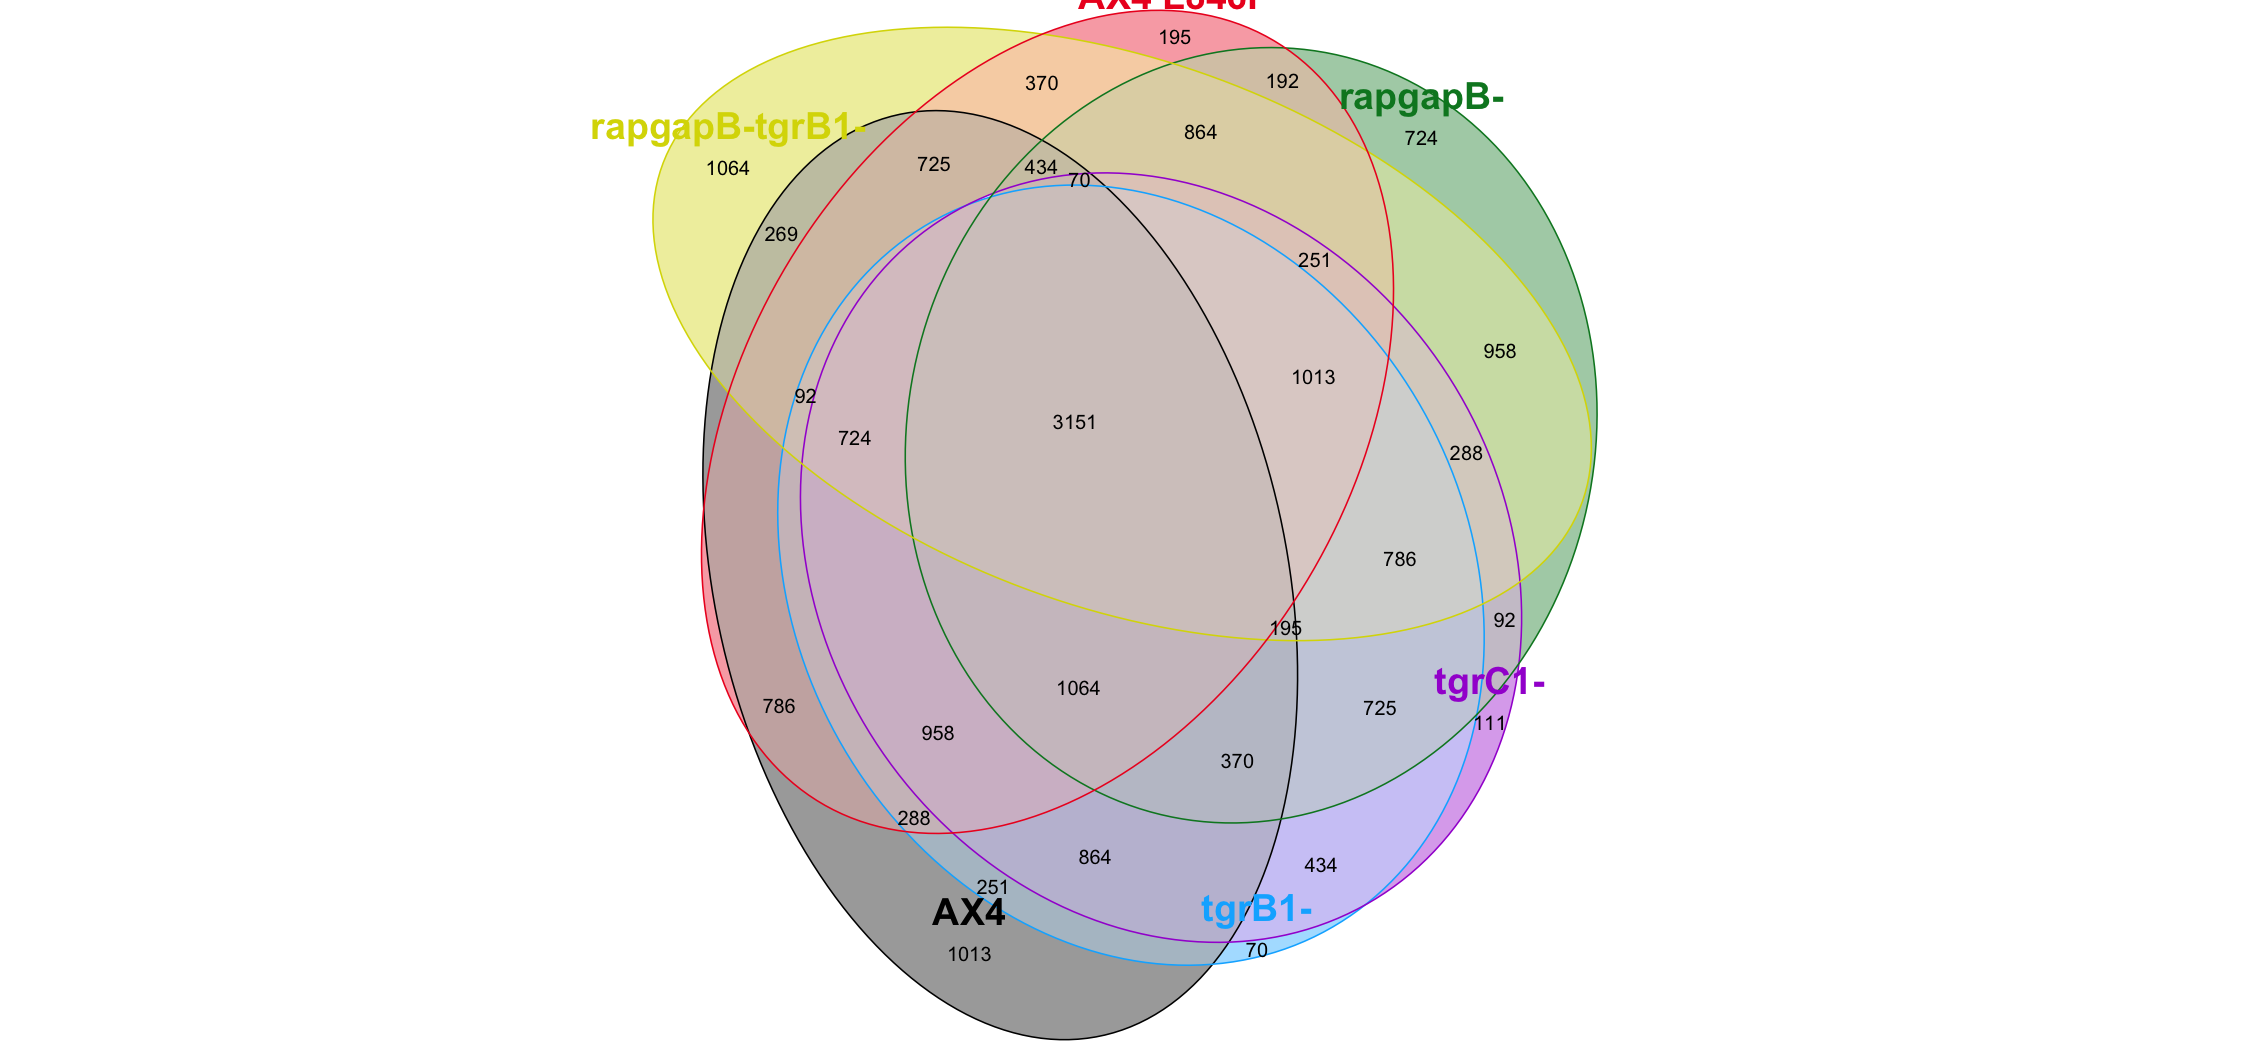

In [87]:
%%R -w 15 -h 7 -u in -r 150
# Load required library
library(eulerr)
set.seed(500)

# Create your data
script_expr <- eval(parse(text = script))
fit <- euler(script_expr, shape = "ellipse")

# Set margins and plot
par(mar = c(6, 6, 6, 6))

plot(
  fit,
  fills = list(
    fill = c("#000000", "#00B2FF", "#A400D3", "#008528", "#D9D800", "#ED1C24"),
    alpha = 0.4
  ),
  edges = c("#000000", "#00B2FF", "#A400D3", "#008528", "#D9D800", "#ED1C24"),
  labels = list(
    font = 2,
    cex = 1.5,
    outer = TRUE,
    col = c("#000000", "#00B2FF", "#A400D3", "#008528", "#D9D800", "#ED1C24")
  ),
  quantities = list(
    cex = 0.8      # optional: make numbers slightly bigger
  ),
  labelspush = TRUE
)


In [88]:
# Uncomment the following lines to save the plot

# %%R
# pdf(pdf_file, width = 15, height = 7)

# library(eulerr)
# set.seed(500)

# # Create your data
# script_expr <- eval(parse(text = script))
# fit <- euler(script_expr, shape = "ellipse")

# # Set margins and plot
# par(mar = c(6, 6, 6, 6))

# plot(
#   fit,
#   fills = list(
#     fill = c("#000000", "#00B2FF", "#A400D3", "#008528", "#D9D800", "#ED1C24"),
#     alpha = 0.4
#   ),
#   edges = c("#000000", "#00B2FF", "#A400D3", "#008528", "#D9D800", "#ED1C24"),
#   labels = list(
#     font = 2,
#     cex = 1.5,
#     outer = TRUE,
#     col = c("#000000", "#00B2FF", "#A400D3", "#008528", "#D9D800", "#ED1C24")
#   ),
#   quantities = list(
#     cex = 0.8      # optional: make numbers slightly bigger
#   ),
#   labelspush = TRUE
# )

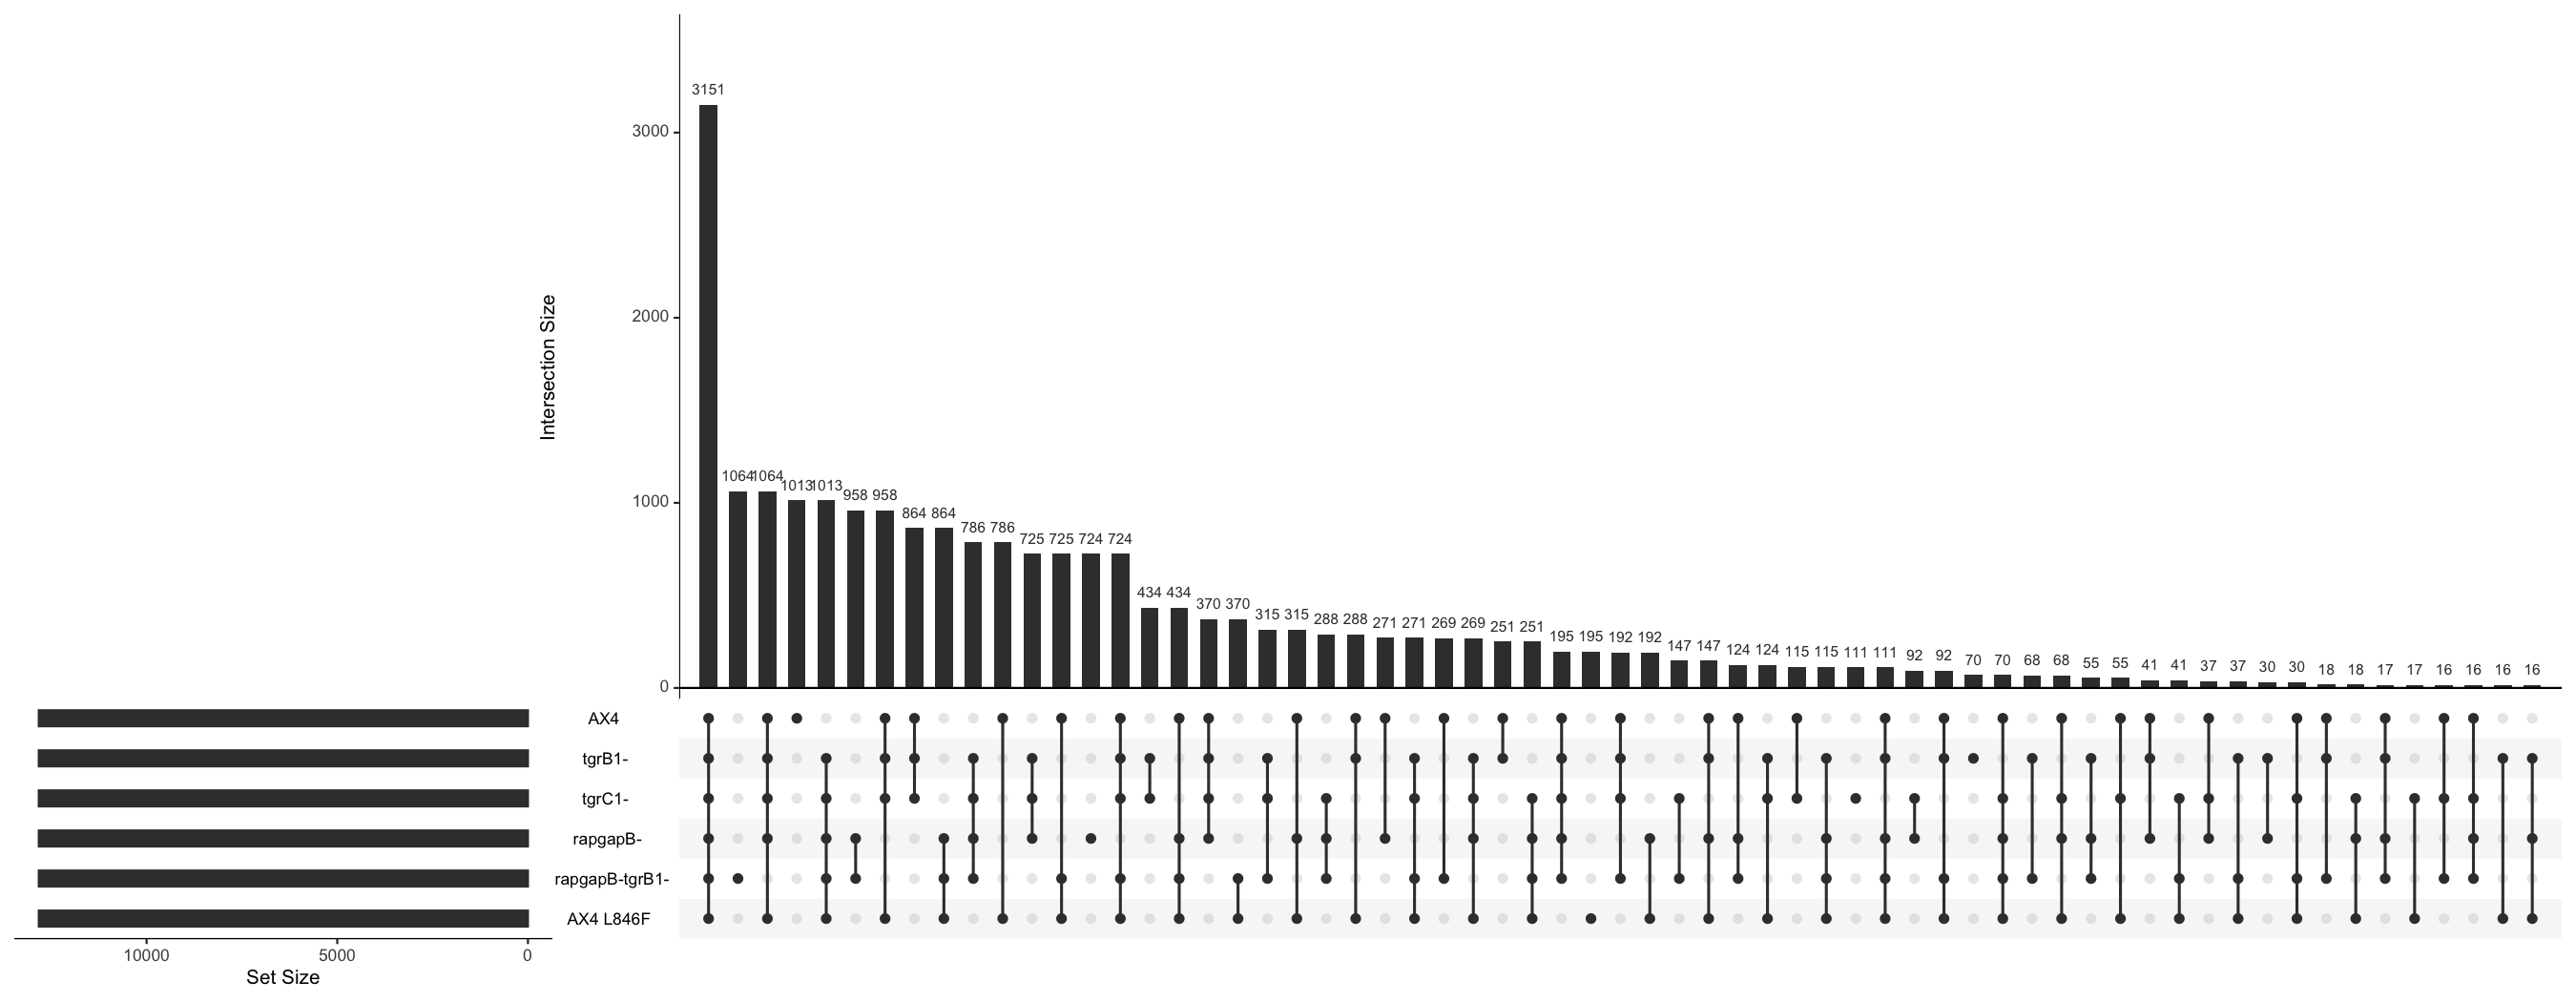

In [89]:
%%R -w 18 -h 7 -u in -r 150
library(UpSetR)
upset_data <- fromExpression(script_expr)
upset(
  upset_data,
  nsets = 6,
  nintersects = NA,
  keep.order = FALSE,
  order.by = "freq",
  text.scale = 1.2,
  number.angles = 0
)

In [ ]:
# %%R
# pdf(pdf_file2, width = 18, height = 7)
# library(UpSetR)
# upset_data <- fromExpression(script_expr)
# upset(
#   upset_data,
#   nsets = 6,
#   nintersects = NA,
#   keep.order = FALSE,
#   order.by = "freq",
#   text.scale = 1.2,
#   number.angles = 0
# )